# Virtual Screening
# 虚拟筛选

In [1]:
import sys
sys.path.append('..')

In [1]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)

/Users/wangyang/Desktop/AI-drug-design/list/02_Basics of drug design/02_virtual-screening/data


# 药物发现过程

---

我们准备开始开发我们的药物发现平台。在之前的工作中，我们学习了创建简单的ADMET预测器。我们训练了溶解度预测模型(回归)和血脑屏障通透性预测模型(分类)。本周，我们将下载活性数据，训练基于配体的活性预测模型。该模型将帮助我们发现与我们的靶标结合的命中点，这是药物设计过程中的第一步。

![drug discovery process overview](mldd_diagram_lab2.png)

# Key Molecular Properties in Drug Design

---

药物设计是一个需要考虑多个参数的过程。首先，该分子需要具有一定的活性，即与其生物靶标相互作用，从而产生一定的治疗效果。其次，该分子还应该具有ADMET (吸收、分布、代谢、排泄和毒性)术语下已知的一组其他理想的分子性质。这些性质保证了我们的化合物会达到它的目标，并且不会产生任何副作用。

## Activity

化合物的生物活性是在实验室中通过进行生物**测定**测定的，以测试我们的分子与其生物靶点的结合和相互作用。测定可以使用蛋白质或全细胞进行，并且可以进行多种类型的活性测量。例如，我们只能测试分子是否与目标结合，或寻找引起理想效果或抑制的特定相互作用。活动值通常表示为：

- **EC$_{50}$**/**IC$_{50}$** - 达到半数效应或抑制(阻断)的分子浓度；这个值越低，分子诱导的效应越强。
- **Ki** - 抑制常数，用来衡量结合亲和力；再次，较低的值对应较强的约束力。
- **Inhibition in %** - 抑制蛋白的百分比。

通常，XC$_{50}$和Ki值被转换为负对数尺度。这用活动类型前面的字母“*p*”表示。此操作减少了极高值的影响。在此转换后，更高的值对应于更强的活动。

For example, pIC$_{50}$ = $-\log_{10} $ IC$_{50}$.


## ADMET

有无数的化学性质可以测量，以确保我们分子的成功。根据药物靶点，我们可能想要优化不同的ADMET特性。如果我们的药物需要在中枢神经系统中发挥作用，我们需要检查**血脑屏障渗透性**。其他口服药物需要**在肠道中吸收**。我们的分子需要**代谢稳定**，这意味着它在到达目的地之前不会被代谢。另一方面，我们需要确保它最终被代谢，并且不会在机体中积累。最终，药物不能**有毒**或通过与其他生物靶点（**非靶点**）相互作用而诱发任何严重的副作用。这是一个难以优化的特性，因为毒性是一种非特异性特性——有许多可能的相互作用会导致毒性，例如**hERG抑制**导致严重的心脏毒性（钾离子通道堵塞将导致心力衰竭）。

---

<div style="display: flex; justify-content: space-between">
    <div style="width: 100%; display: inline-block; margin: 20px">
        <p><strong>我是半吊子(这一块有错误的，请您们指出):</strong> 你好!作为一名专门从事药物化学AIDD的二愣子(半路出家)，我很兴奋地解释了测定化合物效价和结合亲和力的IC50和Ki值的关键过程。在我们的实验中，我们精心设计了微孔板实验，制备了不同浓度的化合物溶液，包括对照，并与我们的目标酶、蛋白质或受体孵育。我们根据目标物的性质采用不同的实验类型，如酶抑制实验、受体结合实验和基于细胞的实验。孵育后，我们测量了酶活性或荧光等活性读数。IC50值是通过分析测量数据产生的剂量-反应曲线来确定的，通常是通过非线性回归，确定其浓度</p>
    </div>
</div>
<div style="width: 80%; display: block; margin: 0 20px 0">
    <p>在设置化合物筛选实验时，仔细的平板设计对结果准确可靠至关重要。每个平板应包括不同浓度的化合物溶液，以及阳性和阴性对照，以验证分析性能。每个条件和技术控制的复制有助于评估实验的可变性，并保证数据的稳健性。将化合物和对照品在整个板上的放置随机化，可以最大限度地减少系统误差，同时避免边缘效应，保持一致性。对板块布局进行细致的记录便于数据分析。中试实验优化检测条件并确认灵敏度。质量控制措施保证了整个筛查过程中检测结果的可靠性。这种综合方法提高了效率。</p>
    </div>

---

# ChEMBL

[ChEMBL](https://www.ebi.ac.uk/chembl/) 是生物活性化合物的公共数据库。这里收集了实验测量的数据点，它们可以用于训练机器学习模型。需要说明的是，该数据库是手工整理的，数据来源于出版物和专利。这些数据的质量并不总是完美的，并且根据实验地点的不同，同一化合物可能具有多个截然不同的活性值。有时这些值可能包含错误，要么是人为造成的，要么是源文件的不正确解析。

![assay](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/96_well_plate.jpg/1599px-96_well_plate.jpg)

从ChEMBL中提取的活动数据可用于训练ML模型。由于我们使用了结构信息(指纹图谱或分子图)，这些模型也被称为**QSAR模型**，其中QSAR代表定量结构-活性关系。

* *练习1 . * *选择下面的一个目标，从ChEMBL下载这个目标的活动数据。使用其中一种活动类型( e.g. Ki或IC$_{50}$)来训练ML模型。对数据进行拆分，并将评价结果打印在测试集上。
- MAO-B (单胺氧化酶B) -其抑制剂可用于治疗帕金森病的症状
- ACE2 (血管紧张素转换酶2) -作为SARS - CoV - 2的切入点
- COX-2 (环氧合酶2 ) -非甾体类抗炎药的靶点
- 5-HT3( 5 -羟色胺受体3) -止吐药(抗呕吐、抗恶心药物)的共同靶点
- hERG -钾离子通道，常与心脏毒性有关(抑制时)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

In [25]:
pd.set_option('display.max_columns', None)
data_path = DATA / 'bioactivities.csv'  
df = pd.read_csv(data_path, sep=',')
df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32262,CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,CHEMBL68920,=,nM,16500.0,CHEMBL279,Homo sapiens,IC50,uM,16.5
1,32335,CHEMBL817617,Inhibition of Vascular endothelial growth fact...,B,CHEMBL69638,=,nM,7100.0,CHEMBL279,Homo sapiens,IC50,uM,7.1
2,33033,CHEMBL812621,Inhibitory activity towards vascular endotheli...,B,CHEMBL419526,=,nM,1880.0,CHEMBL279,Homo sapiens,IC50,nM,1880.0
3,33408,CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,CHEMBL443268,=,nM,10100.0,CHEMBL279,Homo sapiens,IC50,uM,10.1
4,34276,CHEMBL812621,Inhibitory activity towards vascular endotheli...,B,CHEMBL330621,=,nM,19.0,CHEMBL279,Homo sapiens,IC50,nM,19.0


In [26]:
df

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32262,CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,CHEMBL68920,=,nM,16500.0,CHEMBL279,Homo sapiens,IC50,uM,16.500
1,32335,CHEMBL817617,Inhibition of Vascular endothelial growth fact...,B,CHEMBL69638,=,nM,7100.0,CHEMBL279,Homo sapiens,IC50,uM,7.100
2,33033,CHEMBL812621,Inhibitory activity towards vascular endotheli...,B,CHEMBL419526,=,nM,1880.0,CHEMBL279,Homo sapiens,IC50,nM,1880.000
3,33408,CHEMBL816964,Inhibition of tyrosine phosphorylation in cell...,B,CHEMBL443268,=,nM,10100.0,CHEMBL279,Homo sapiens,IC50,uM,10.100
4,34276,CHEMBL812621,Inhibitory activity towards vascular endotheli...,B,CHEMBL330621,=,nM,19.0,CHEMBL279,Homo sapiens,IC50,nM,19.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9144,25104818,CHEMBL5262915,Inhibition of VEGFR-2 (unknown origin),B,CHEMBL184750,=,nM,654.0,CHEMBL279,Homo sapiens,IC50,uM,0.654
9145,25104819,CHEMBL5262915,Inhibition of VEGFR-2 (unknown origin),B,CHEMBL187431,=,nM,29400.0,CHEMBL279,Homo sapiens,IC50,uM,29.400
9146,25104820,CHEMBL5262915,Inhibition of VEGFR-2 (unknown origin),B,CHEMBL186001,=,nM,200.0,CHEMBL279,Homo sapiens,IC50,uM,0.200
9147,25104821,CHEMBL5262915,Inhibition of VEGFR-2 (unknown origin),B,CHEMBL5273702,=,nM,350.0,CHEMBL279,Homo sapiens,IC50,uM,0.350


In [27]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)
len(df_train), len(df_test)

(7319, 1830)

In [28]:
# TODO: Use your training script
# 根据目标选择活性类型
activity_type = 'IC50'

# 选择特征和标签   
X_train = df_train.drop(['Molecule ChEMBL ID', 'Standard Type', 'Standard Value', 'Activity Comment', 'Assay ChEMBL ID'], axis=1)
y_train = df_train[activity_type]

X_test = df_test.drop(['Molecule ChEMBL ID', 'Standard Type', 'Standard Value', 'Activity Comment', 'Assay ChEMBL ID'], axis=1)
y_test = df_test[activity_type]

# 训练模型
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 评估模型
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")   

KeyError: "['Molecule ChEMBL ID', 'Standard Type', 'Standard Value', 'Activity Comment', 'Assay ChEMBL ID'] not found in axis"

If you want to automate your data pipelines, you can use the ChEMBL Python API, as shown in the example below.

In [36]:
from chembl_webresource_client.new_client import new_client
from tqdm.notebook import tqdm

target = new_client.target
activity = new_client.activity
bace = target.filter(pref_name__iexact='Beta secretase 2').only('target_chembl_id')[0]
activities_provider = activity.filter(target_chembl_id=bace['target_chembl_id']).filter(standard_type="IC50")
activities = list(tqdm(activities_provider))
df_bace = pd.DataFrame.from_records(activities)

In [43]:
molecule = new_client.molecule
compounds_provider = molecule.filter(
    molecule_chembl_id__in=list(df_bace["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")
compounds = list(tqdm(compounds_provider))
df_cmpds = pd.DataFrame.from_records(compounds)
print(f"DataFrame shape: {df_cmpds.shape}")

**(optional) Excercise 1.1.** *(advanced data splitting methods)*

You might be surprised how good results you can achieve using a random data split. The model performance measured this way can be misleading as ChEMBL contains many similar compounds, series of compounds containing the same scaffold, or even duplicated records. Thus, a better form of evaluation would be to employ a more advanced splitting method, e.g. **scaffold-based split** in which all compounds containing the same scaffold are put in the same set. Another option is to use a **time-based split** because most records in ChEBML should be tagged with the date of their publication. 

Don't be discouraged by the lower results you obtain with these splits. By evaluating your model this way, you get more realistic scores that better reflect the future use cases of your model. The fact that lower evaluation scores may correspond to a better model is known as the **Kubinyi paradox**.

You can now implement a more advanced data split and compare the prediction results on the testing set.

In [ ]:
# TODO repeat training with scaffold/time/clustering-based split

**(optional) Excercise 1.2.** *(label transformations)*

As mentioned above, using the logarithmic values can improve the prediction results by eliminating extreme values. Another option is to transform continuous measurements into binary classes, where active compounds are those with IC$_{50}$/Ki values below a certain treshold, and the rest is assumed inactive. This approach can also help dealing with inaccurate noisy measurements.

Try to convert labels into pIC$_{50}$/pKi values or change the regression task to a binary classification problem.

In [ ]:
activity_threshold = 100
df['class'] = (df['Standard Value'] <= activity_threshold).astype(int)
df

In [ ]:
# TODO: classification setup

**(optional) Excercise 1.3.** *(exploratory data analysis, data filtering)*

Can you find any discrepancies in the data? For example, do you find any outliers or duplicated SMILES strings? Can you solve these problems?

In [ ]:
# Hint: A dot in the SMILES string indicates multiple compounds (this is a separator)
df[df.Smiles.str.contains('\.')]

# TODO: Perform Exploratory Data Analysis

# ZINC

[ZINC](https://zinc.docking.org/) is a database of commercially available compounds. This data can be used for **virtual screening**, i.e. finding active molecules using only *in silico* (computer) methods. These compounds can be then purchased and tested *in vitro* (in cells or biomolecules) or *in vivo* (in living organisms).

---

<div style="display: flex; justify-content: space-between">
    <div style="width: 20%; display: inline-block; margin: 20px">
        <img src="../../assets/profile1.png" width="100%">
    </div>
    <div style="width: 60%; display: inline-block; margin: 20px">
        <p><strong>Nitro:</strong> Hi there! In hit discovery, high-throughput screening plays a crucial role by swiftly evaluating vast compound libraries for potential drug candidates. Molecules for screening can be sourced from diverse sources such as chemical libraries, natural products, or even synthesized compounds. In high-throughput experiments utilizing commercially available compound libraries, thousands to millions of compounds are screened simultaneously against a specific biological target. Typically, automated robotic systems handle the process, dispensing small volumes of compounds into assay plates containing the target of interest. These assays are designed to detect interactions between the compounds and the target, such as binding or inhibition. Following incubation, the plates are analyzed using various detection methods, such as fluorescence, luminescence, or absorbance, to identify hits. Hits are compounds that exhibit the desired activity or effect on the target. These experiments enable rapid screening of immense compound libraries, accelerating the hit discovery process in drug development.</p>
    </div>
</div>
<div style="width: 80%; display: inline-block; margin: 0 20px 0">
        <p>Techniques like DNA-Encoded Libraries (DELs), fragment-based screens, and phenotypic screens offer distinct approaches to identify hits. DELs enable rapid screening of extensive compound collections with unique DNA tags, while fragment-based screens focus on identifying small, low molecular weight compounds that may serve as starting points for drug development. Phenotypic screens, on the other hand, assess compounds based on their cellular effects, allowing for the discovery of drugs for complex diseases. Phenotypic screening, such as high-content screening, can measure various cellular features and processes in fluorescence microscopy images, including cell morphology, protein localization, organelle structure, cell cycle progression, and changes in signaling pathways or gene expression levels. Each technique has its strengths, contributing to the efficiency and success of hit discovery endeavors.</p>
</div>

---

**Exercise 2.** Perform virtual screening. Use the data in the `mystery_target.csv` file to train a model and use it to find the most active compounds in a ZINC subset. Which compounds should be selected to be purchased or synthesized?

Save the output as a CSV file containing 100 compounds (SMILES strings) and their predicted activity values.

In [ ]:
# TODO: inference: (1) load data (2) convert representation (3) predict activity (4) show drug candidates
df = pd.read_csv('data/mystery_target.csv')

# save the selected 100 compounds
results.to_csv('results.csv')

**(optional) Exercise 2.1.** *(Compound novelty and diversity)*

How similar are the selected compounds to the training data? Can you measure the diversity of these compounds? How should these values impact your selection?

In [ ]:
# TODO: Check structural similarity

---

<div style="display: flex; justify-content: space-between">
    <div style="width: 20%; display: inline-block; margin: 20px">
        <img src="../../assets/profile2.png" width="100%">
    </div>
    <div style="width: 60%; display: inline-block; margin: 20px">
        <p><strong>Ester:</strong> 
Hey there, fellow data voyagers and knowledge seekers! In data analysis, especially in fields like chemistry and biology, we often deal with datasets that have a large number of features or dimensions. Each feature represents a different aspect or property of the data. While having a rich set of features can provide valuable insights, it can also pose challenges. One such challenge is the curse of dimensionality.</p>
        <p>As the number of dimensions increases, the amount of data required to generalize accurately increases exponentially. Moreover, high-dimensional data can be difficult to visualize and interpret, making it challenging to extract meaningful patterns or relationships.</p>
        <p>This is where dimensionality reduction techniques come into play. Dimensionality reduction refers to the process of reducing the number of features in a dataset while preserving as much relevant information as possible.</p>
    </div>
</div>
<div style="width: 80%; display: inline-block; margin: 0 20px 0">
<h4>Principal Component Analysis (PCA):</h4>

Imagine you have a bunch of points in space representing different things (like chemicals). PCA helps you find the most important directions (called principal components) along which these points vary the most. It squishes and rotates the space so that the first principal component points in the direction where the data varies the most, the second principal component points in the direction where the data varies the second most, and so on. This helps in reducing the dimensions of the data while retaining most of its variance.

<h4>t-Distributed Stochastic Neighbor Embedding (t-SNE):</h4>

t-SNE is like PCA's more artistic cousin. Instead of just focusing on variance, it's more interested in keeping similar things close together and dissimilar things far apart. It measures the similarity between points in high-dimensional space and then tries to represent those similarities in a lower-dimensional space. It's really good at preserving local structure, so nearby points in high-dimensional space tend to stay nearby in the visualization.

<h4>Insights from these plots:</h4>

From PCA plots, you can see which properties of chemicals contribute most to their variation. For example, you might find that compounds with similar structures or properties cluster together.

From t-SNE plots, you can see how similar or dissimilar compounds are to each other. Clusters of similar compounds will appear as tight groups, while outliers or distinct classes will be more spread out.

In both cases, these plots help chemists understand the relationships between different chemicals, identify outliers, and potentially discover new trends or groupings that were not immediately obvious from the raw data.
</div>

---

You can use **t-SNE** to find structural similarities in your dataset. t-SNE is a tool for high-dimensional data visualization (**dimensionality reduction**). It transforms n-dimensional data into 2-dimensional map in which distances should be proportional to the distances in the original space.

In [12]:
from sklearn.manifold import TSNE

def get_morgan(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=4)
    return np.array(fingerprint)

df_zinc = pd.read_csv('zinc.smi', sep=' ', index_col=1).sample(n=1000)
df_zinc['fingerprint'] = [get_morgan(smiles) for smiles in df_zinc.smiles]

In [21]:
tsne = TSNE(metric='jaccard')
components = tsne.fit_transform(np.stack(df_zinc.fingerprint))

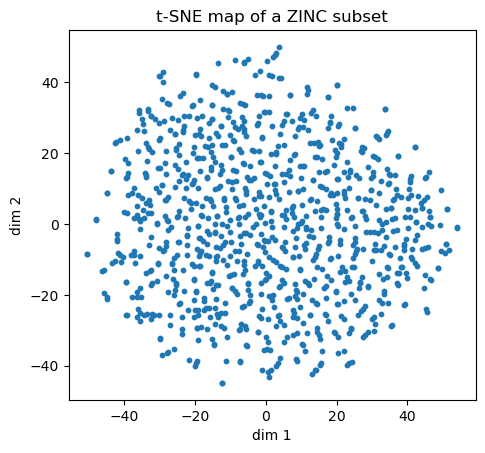

In [23]:
plt.scatter(components[:, 0], components[:, 1], s=10)
plt.gca().set_aspect('equal')
plt.title('t-SNE map of a ZINC subset')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.show()

**(optional) Exercise 2.2.** *(Additional ADMET filters)*

When selecting compounds, we need to consider also other properties, e.g. toxicity. Some structural patterns are well known to cause issues in terms of toxicity or synthesizability. We can quickly filter out compounds containing these patterns using their SMARTS strings ("regular expressions" for SMILES).

Use [SureChEMBL](https://www.surechembl.org/search/) to remove problematic compounds.

In [ ]:
# TODO: Use SMARTS to filter out compounds

# PubChem

[PubChem](https://pubchem.ncbi.nlm.nih.gov/) is a database of chemical information about small molecules. It contains various ADMET properties and 3D crystal structures of these molecules. You can easily find any compound using the SMILES representation or by drawing the structure in the tool on the website.

**(optional) Exercise 3.** What information can you find about your selected top compounds?